<a href="https://colab.research.google.com/github/marco-finger/derLauch/blob/main/CodingTask1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Science Fundamentals for DCBP, S. Haug, University of Bern 

# Coding Task 1

- Deadline (upload to Ilias): 2022-03-20 24:00
- Estimated effort: 2-5 hours
- Data on Ilias (4ms_...) with metadata file CCD-Metadata


## Tasks (maximum 12.5 points)

- Write a method (function) which removes the header information in the datafile and saves that information into a separate textfile. [0.5 points] 
- Write a function which reduces the data resolution by averaging over 1, 2, 3 and 4 nm wavelengths. Save these 4 new reduced datasets in new files. Do this (1) by writing an explicit loop and (2) by using pandas methods. Measure the running times of the two approaches. [6 points]
- Write a function which takes two wavelengths as input and plots the difference of the data at these lengths over time. [2 points] 
- Let the x-axis be in seconds, label the axes with names and units, label the plot with color and legend, make a title for the plot. Save the plot to a file. [2 points]
- Plot the full and the reduced datasets in the same figure. Is there any visual difference? [2 points]

In [2]:
# import of standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# mount dataset from Google drive
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/DSF-FS22/data/4ms_10 av_30 s_Absorbance_10-32-04-868.txt'
df = pd.read_csv(path, delimiter='\t', header = 13) # header taken as from column 13 (wavelengths)
df = df.drop(columns = "Unnamed: 0") # removes the redundant first column

Mounted at /content/drive


### 1. Removing header (0.5 points)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355 entries, 0 to 354
Columns: 3649 entries, Unnamed: 1 to 780.0381
dtypes: float64(3648), int64(1)
memory usage: 9.9 MB


In [5]:
df.describe()

,Unnamed: 1,316.6137,316.7492,316.8847,317.0203,317.1558,317.2913,317.4268,317.5623,317.6977,...,778.9703,779.089,779.2076,779.3263,779.4449,779.5636,779.6822,779.8008,779.9194,780.0381
count,3.550000e+02,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,...,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000
mean,1.540456e+12,0.409207,0.409207,0.409207,0.120755,-0.332947,-1.138412,-0.273126,0.036164,-0.026767,...,-0.037705,-0.037621,-0.036954,-0.035224,-0.037010,-0.036702,-0.037107,-0.036634,-0.037724,-0.035371
std,8.676718e+03,0.327439,0.327439,0.327439,0.225739,0.368498,0.926140,0.318666,0.331674,0.756225,...,0.001611,0.001573,0.001648,0.001574,0.001522,0.001571,0.001649,0.001624,0.001545,0.001536
min,1.540456e+12,-0.243277,-0.243277,-0.243277,-0.504316,-0.879836,-2.446382,-0.772345,-0.629352,-0.809866,...,-0.041032,-0.040494,-0.039786,-0.039203,-0.040537,-0.040524,-0.040304,-0.039905,-0.040929,-0.038231
25%,1.540456e+12,0.103420,0.103420,0.103420,-0.016814,-0.600144,-1.975407,-0.483988,-0.005090,-0.200815,...,-0.038473,-0.038412,-0.037876,-0.036055,-0.037728,-0.037505,-0.037930,-0.037541,-0.038611,-0.036165
50%,1.540456e+12,0.330891,0.330891,0.330891,0.076447,-0.424603,-1.462398,-0.339107,0.000000,0.000000,...,-0.037737,-0.037731,-0.036998,-0.035267,-0.037119,-0.036722,-0.037191,-0.036708,-0.037786,-0.035425
75%,1.540456e+12,0.844202,0.844202,0.844202,0.212742,-0.124390,-0.000000,-0.114209,0.016706,-0.000000,...,-0.037022,-0.036934,-0.036270,-0.034529,-0.036315,-0.035969,-0.036296,-0.035855,-0.036984,-0.034661
max,1.540456e+12,0.871232,0.871232,0.871232,2.056905,1.344611,0.301030,1.797614,2.025306,12.746800,...,-0.016370,-0.016801,-0.014841,-0.014077,-0.017539,-0.015907,-0.016059,-0.015445,-0.016981,-0.014757


In [6]:
df.head()

,Unnamed: 1,316.6137,316.7492,316.8847,317.0203,317.1558,317.2913,317.4268,317.5623,317.6977,...,778.9703,779.089,779.2076,779.3263,779.4449,779.5636,779.6822,779.8008,779.9194,780.0381
0,1540456324789,0.329672,0.329672,0.329672,0.090294,-0.716926,-1.829304,-0.686330,-0.428776,1.740363,...,-0.038483,-0.039623,-0.036920,-0.037309,-0.037299,-0.037476,-0.036856,-0.036853,-0.039100,-0.035545
1,1540456324878,-0.044412,-0.044412,-0.044412,0.157632,-0.672423,-2.183981,-0.492421,-0.000000,-0.695800,...,-0.039428,-0.038486,-0.037309,-0.036357,-0.037289,-0.038728,-0.037214,-0.036902,-0.040210,-0.038165
2,1540456324962,0.338219,0.338219,0.338219,0.330993,-0.879836,-0.000000,-0.559845,-0.000000,-0.275276,...,-0.037725,-0.037534,-0.036560,-0.036152,-0.036554,-0.036875,-0.037351,-0.036746,-0.038686,-0.036903
3,1540456325046,-0.049682,-0.049682,-0.049682,0.519086,-0.681150,-0.000000,-0.417230,-0.000000,-0.140451,...,-0.037613,-0.037168,-0.036369,-0.034549,-0.036252,-0.037948,-0.036713,-0.035706,-0.038203,-0.036822
4,1540456325129,0.335086,0.335086,0.335086,-0.041393,-0.000000,-1.802774,-0.510417,-0.000000,-0.000000,...,-0.040919,-0.038288,-0.035840,-0.035638,-0.039504,-0.040093,-0.039953,-0.037656,-0.038082,-0.035900


In [7]:
df.to_csv('/content/drive/MyDrive/DSF-FS22/data/task1/CCD-Data.csv') # creates a csv file containg only the data and saves it into a folder called "task1"

In [ ]:
# % ls -l

### 2. Reducing data resolution (6 points)


In [8]:
print(df.iloc[2, 10])
print(df.columns[10])
#df.plot([0,1:1000])

0.627907
317.8332


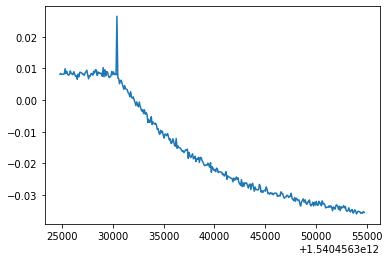

In [9]:

x = df.iloc[:,0]
y = df.iloc[:,1950]
plt.plot(x,y)

(3647,)


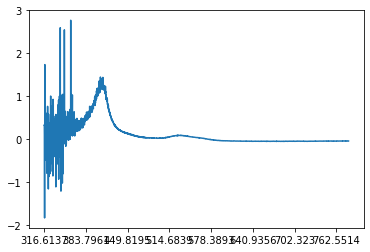

In [10]:
# x = df.iloc[0,1:-1]
# y = df.iloc[10,:]
# plt.plot(x,y)

df1 = df.iloc[0,1:-1]
print(df1.shape)
df1.plot()

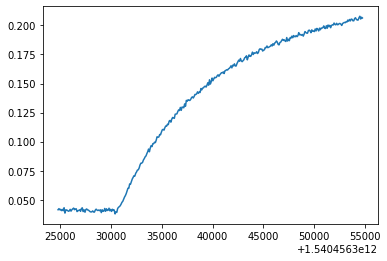

In [11]:
x = df.iloc[:,0]
y = -(df.iloc[:,1950]-df.iloc[:,1800])
plt.plot(x,y)

In [80]:
time = df.iloc[:,0]

time_zero = time[0]

L = []

for i in range(len(time)):
  time[i] = time[i] - time_zero
  L.append(time[i])
print(L)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


[0, 1, -2, 1, -4, 8, -8, 8, -4, 0, -1, -2, 7, -12, 16, -8, 0, 0, 1, -2, -3, 4, 4, -4, 0, -4, 8, -16, 23, -10, -1, 0, 0, 0, 0, 1, -2, -3, 8, -4, 0, 0, 0, 0, -4, 8, -5, 2, -1, -4, 8, -3, -2, -3, 8, -4, 0, 0, 0, 0, 0, 0, 0, -4, 8, -4, -1, 2, 0, -6, 9, -4, 0, -4, 8, -4, 0, 0, 0, 0, 0, 0, 0, 0, 0, -4, 8, -8, 8, -4, 0, 0, -4, 8, -4, 0, 0, 0, 0, 0, 0, 0, 1, -3, 3, -1, 0, 0, 0, 0, 0, 0, 0, 0, -4, 8, -4, 0, -4, 9, -6, 1, -1, -2, 7, -4, 0, 0, -4, 8, -4, 0, 0, 0, -4, 9, -6, 1, 0, 0, -4, 7, -2, -1, 0, 0, 0, 0, 0, 0, -4, 8, -7, 6, -3, 0, 0, 0, 0, -1, 2, -1, 0, 0, 0, 0, 0, -4, 8, -3, -2, 1, 0, 0, 0, 0, 0, 0, -1, 2, -1, 0, 0, -4, 8, -4, 1, -2, -3, 8, -4, -4, 8, -8, 8, -4, 0, -1, 2, -1, 0, 0, 0, 1, -2, -3, 8, -4, 0, 0, 0, 0, 0, 0, 0, 0, -5, 10, -5, 1, -2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 3, -3, 1, -4, 8, -4, 0, 0, 0, 0, 0, 0, -4, 8, -4, 0, 0, -8, 16, -8, 0, 0, 0, 0, 0, 0, 0, 0, 0, -4, 8, -4, 0, 0, 1, -2, 0, 2, -1, 0, -4, 8, -4, 0, -4, 4, -12, 28, -16, 0, 1, -2, 1, 0, -1, 2, -1, 0, 0, 0, 0

In [61]:
type(time)

pandas.core.series.Series

In [83]:
# df[0].apply(lambda x: x-df.iloc[[0],[1]])